In [1]:
## Run the following command in the terminal to install necessary dependencies (seems like need to install in this order to work properly)
##
## pip install git+ssh://git@github.com/aws/amazon-braket-schemas-python.git@quera 
## pip install git+ssh://git@github.com/aws/amazon-braket-sdk-python.git@feature/ahs
## pip install git+ssh://git@github.com/aws/amazon-braket-default-simulator-python-staging.git@feature/neutral-atom-simulator-solvers


# Ordered phases in rydberg systems

In this example notebook, we will introduce the ordered phases in Rydberg systems, with focus on the 1D $Z_2$ phase and the 2D checkerboard phase.

## Introduction of Rydberg Hamiltonian


## Adiabatic evolution

We begin by importing the necessary packages.

In [1]:
import numpy as np
pi = np.pi
from braket.ahs.atom_arrangement import AtomArrangement, SiteType
import matplotlib.pyplot as plt

from braket.ahs.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.analog_hamiltonian_simulator.rydberg.rydberg_simulator import RydbergAtomSimulator

## 1D $Z_2$ phase 

Here we consider a 1D chain of 9 atoms with neighboring atoms separated by $5.5\mu m$. The setup of the system can be generated as follows

In [3]:
register = AtomArrangement()
separation = 5.5e-6  # in meters 
num_atoms = 5

for k in range(num_atoms):
    register.add((k*separation, 0))

Let us plot the arrangment of the atoms and confirm that the setup is properly prepared. 

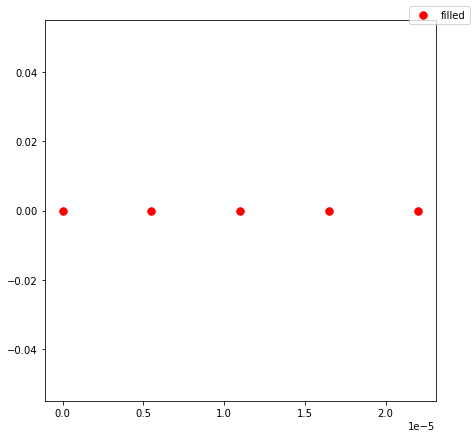

In [4]:
def show_register(register):
    filled_sites = [site.coordinate for site in register._sites if site.site_type == SiteType.FILLED]
    fig = plt.figure(figsize=(7, 7))
    plt.plot(np.array(filled_sites)[:, 0], np.array(filled_sites)[:, 1], 'r.', ms=15, label='filled')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    
show_register(register)

In order to prepare the $Z_2$ ordered state for the atomic chain, we shall design an analog Hamiltonian simulation  (AHS) program that drives the system to the desired state adiabatically. The program consists three parts: the amplitude and phase of the Rabi frequency and the detuning. They can be specified as follows.

In [5]:
amplitude_min = 0          # rad / s
amplitude_max = 4*pi*1e6   # rad / s

detuning_min = -8*pi*1e6  # rad / s
detuning_max = 20*pi*1e6   # rad / s

time_max = 5e-6  # s
time_ramp = 5e-7  # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

amplitude = TimeSeries()
for t, v in zip(time_points, amplitude_values):
    amplitude.put(t, v)

detuning = TimeSeries()
for t, v in zip(time_points, detuning_values):
    detuning.put(t, v)

phase = TimeSeries()
for t, v in zip(time_points, phase_values):
    phase.put(t, v)

# Note: Since all attributes of QuEra Aquila's driving field are uniform,
#       we pass the TimeSeries objects directly to the constructor.
#       This will contruct braket.ahs.field.Field objects with uniform patterns for the attributes.
drive = DrivingField(
    amplitude=amplitude, 
    detuning=detuning, 
    phase=phase
)

We can plot the waveforms of these driving fields to make sure that they are correctly specified.

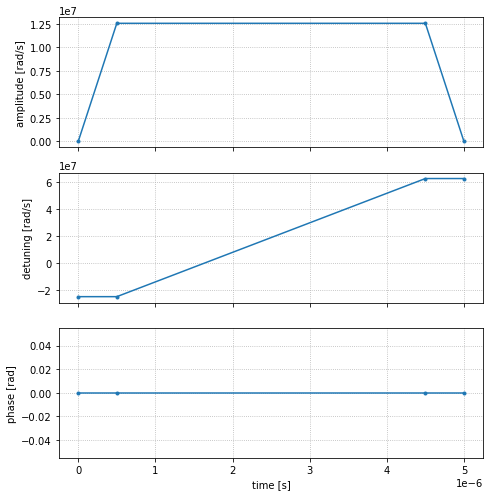

In [6]:
def show_global_drive(drive):
    data = {
        'amplitude [rad/s]': drive.amplitude.time_series,
        'detuning [rad/s]': drive.detuning.time_series,
        'phase [rad]': drive.phase.time_series,
    }
    
    fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)
    for ax, data_name in zip(axes, data.keys()):
        ax.plot(data[data_name].times(), data[data_name].values(), '.-')
        ax.set_ylabel(data_name)
        ax.grid(ls=':')
    axes[-1].set_xlabel('time [s]')
    plt.tight_layout()

show_global_drive(drive)

Finally the AHS program of interest is the collection of the atomic registers, and the Hamiltonian defined above. 

In [7]:
hamiltonian = Hamiltonian()
hamiltonian += drive

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=hamiltonian
)

ahs_program_ir = ahs_program.to_ir()

Before runnig the program on Quera's device, we can first run it on the local simulator to make sure the outcome is the expected $Z_2$ state. 

Say sth about validation.

In [8]:
device = RydbergAtomSimulator()
result = device.run(ahs_program_ir)

The input program is being validated.



/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/waveform.py:39: UserWarning: Max time is 0.000005 which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/blockade_radius.py:17: UserWarning: Blockade radius 0.0 meter is smaller than the typical value (1e-06 meter). The blockade radius should be specified in SI units.
  warnings.warn(


To confirm the $Z_2$ state, we extract and plot the average Rydberg density as follows.

In [22]:
def get_avg_density(result):
    measurements = result.measurements
    postSeqs = [measurement.shotResult.postSequence for measurement in measurements]
    
    avg_density = np.sum(np.array(postSeqs), axis=0)/len(postSeqs)
    
    return avg_density

def show_final_avg_density(result):
    avg_density = get_avg_density(result)
    
    plt.bar(range(len(avg_density)), get_avg_density(result))
    plt.xlabel("Indices of atoms")
    plt.ylabel("Average Rydberg density")

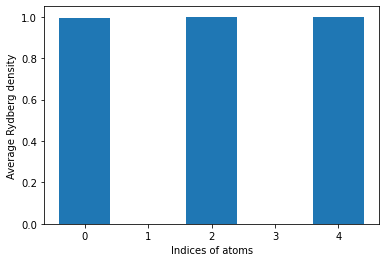

In [23]:
show_final_avg_density(result)

## 2D checkerboard phase 

In two dimension, Rydberg system can exhibit the checkerboard phase, which is analogues to the $Z_2$ phase in 1D. For simplicity, here we create a two dimensionl $3\times3$ atomic array. 

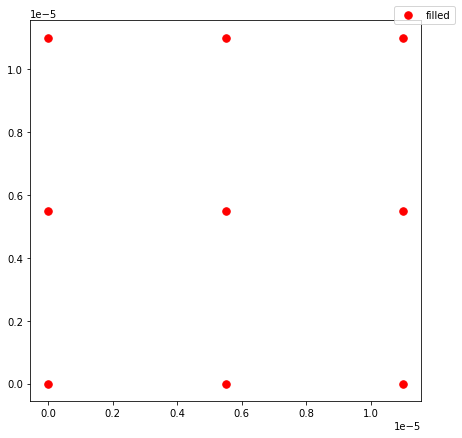

In [24]:
register_2D = AtomArrangement()
separation = 5.5e-6  # in meters 
num_atoms = 3

for k in range(num_atoms):
    for l in range(num_atoms):
        register_2D.add((k*separation, l*separation))

show_register(register_2D)

Without loss of generality, we shall use the same Hamiltonian as the one used for realizing the $Z_2$ phase in the 1D atomic chain. 

In [25]:
hamiltonian = Hamiltonian()
hamiltonian += drive

ahs_program_2D = AnalogHamiltonianSimulation(
    register=register_2D, 
    hamiltonian=hamiltonian
)

ahs_program_2D_ir = ahs_program_2D.to_ir()

result_2D = device.run(ahs_program_2D_ir)

The input program is being validated.



/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/waveform.py:39: UserWarning: Max time is 0.000005 which is bigger than the typical scale (0.000004 seconds). The time points should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/blockade_radius.py:17: UserWarning: Blockade radius 0.0 meter is smaller than the typical value (1e-06 meter). The blockade radius should be specified in SI units.
  warnings.warn(


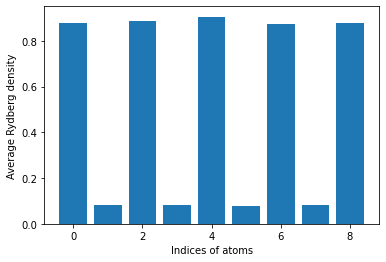

In [27]:
show_final_avg_density(result_2D)